<a href="https://colab.research.google.com/github/andygoosh/samsung/blob/master/Arxiv_title_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Mon Mar 16 07:24:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from pathlib import Path
from google.colab import files, drive
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

%tensorflow_version 2.x
import tensorflow as tf

import torch
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'cpu')
# V100 (7~7.8 TF) -> P100 (4.7~5.3 TF, LoNi) -> K80 (1.87+ TF, LoNi) -> T4 (~0.25 TF, Andy/Nik) -> P6 (Andy/Goosh) ->P4 (LoNi)
    
gpath = Path('/content/gdrive')
drive.mount(str(gpath))
data_file = gpath / 'My Drive/Samsung' / 'train.csv.zip'

TensorFlow 2.x selected.
Tesla P100-PCIE-16GB
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import zipfile
from io import BytesIO
from urllib.request import urlopen

def zipfile_to_corpus(corpus_file_name):
  with zipfile.ZipFile(BytesIO(urlopen(corpus_file_name).read())) as f:
      data = tf.compat.as_str(f.read(f.namelist()[0]))

# from torchtext.data.metrics import bleu_score

In [5]:
train_df = pd.read_csv(data_file)
train_df

,abstract,title
0,we consider the problem of utility maximizatio...,on optimal investment with processes of long o...
1,in this paper we provide an explicit formula f...,boolean complexes for ferrers graphs
2,"kinesin-5, also known as eg5 in vertebrates is...",relative velocity of sliding of microtubules b...
3,we discuss the transition paths in a coupled b...,bifurcation of transition paths induced by cou...
4,two types of room temperature detectors of ter...,all-electric detectors of the polarization sta...
...,...,...
134995,we consider a minimalistic dynamic model of th...,randomly evolving idiotypic networks: structur...
134996,this is an extended version of a communication...,noncommutative generalization of su(n)-princip...
134997,"in this paper, a new method was developed for ...",initialization of multilayer forecasting artif...
134998,we propose a new approach to analyze data that...,principal arc analysis on direct product manif...


Abstract max len 584
Title max len 39


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 127 missing from current font.
  font.set_text(s, 0, flags=flags)


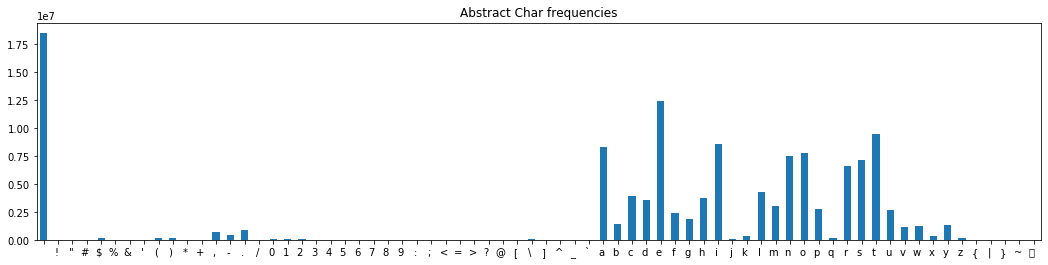

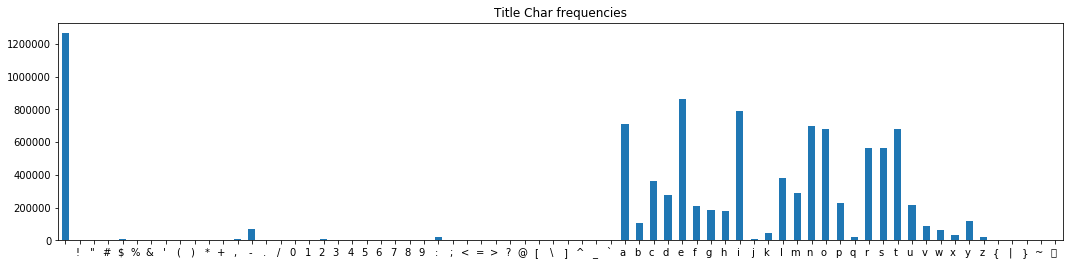

In [6]:
chars_abs = Counter()
chars_ttl = Counter()

abs_len = 0
ttl_len = 0

for row in range(len(train_df)):
  chars_abs += Counter(train_df.abstract[row])
  chars_ttl += Counter(train_df.title[row])

  abs_len = max(abs_len, len(train_df.abstract[row].split()))
  ttl_len = max(ttl_len, len(train_df.title[row].split()))


s = sorted(chars_abs.items())
pd.DataFrame(s, index=(e[0]+' ' for e in s)).plot.bar(figsize=(18,4), rot=0, title = 'Abstract Char frequencies', legend=False);
print(f'Abstract max len {abs_len}')

s = sorted(chars_ttl.items())
pd.DataFrame(s, index=(e[0]+' ' for e in s)).plot.bar(figsize=(18,4), rot=0, title = 'Title Char frequencies', legend=False);
print(f'Title max len {ttl_len}')

In [11]:
!pip install transformers

     |████████████████████████████████| 501kB 8.1MB/s 
     |████████████████████████████████| 1.0MB 19.4MB/s 
     |████████████████████████████████| 870kB 44.9MB/s 
     |████████████████████████████████| 3.7MB 54.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=7ce346f85c5d21b28d5130a387253d6e7869c19abe9f42f7790ed4e7df3e3246
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [12]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Print the original sentence.
print(' Original: ', train_df.abstract[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_df.abstract[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_df.abstract[0])))

Loading BERT tokenizer...



 Original:  we consider the problem of utility maximization for investors with power utility functions. building on the earlier work larsen et al. (2016), we prove that the value of the problem is a frechet-differentiable function of the drift of the price process, provided that this drift lies in a suitable banach space.   we then study optimal investment problems with non-markovian driving processes. in such models there is no hope to get a formula for the achievable maximal utility. applying results of the first part of the paper we provide first order expansions for certain problems involving fractional brownian motion either in the drift or in the volatility. we also point out how asymptotic results can be derived for models with strong mean reversion.
Tokenized:  ['we', 'consider', 'the', 'problem', 'of', 'utility', 'maxim', '##ization', 'for', 'investors', 'with', 'power', 'utility', 'functions', '.', 'building', 'on', 'the', 'earlier', 'work', 'larsen', 'et', 'al', '.', '(', '

In [0]:
import tensorflow_hub as hub
import bert

BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [0]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_df.abstract]
print (tokenized_texts[0])

['we', 'consider', 'the', 'problem', 'of', 'utility', 'maxim', '##ization', 'for', 'investors', 'with', 'power', 'utility', 'functions', '.', 'building', 'on', 'the', 'earlier', 'work', 'larsen', 'et', 'al', '.', '(', '2016', ')', ',', 'we', 'prove', 'that', 'the', 'value', 'of', 'the', 'problem', 'is', 'a', 'fr', '##eche', '##t', '-', 'different', '##iable', 'function', 'of', 'the', 'drift', 'of', 'the', 'price', 'process', ',', 'provided', 'that', 'this', 'drift', 'lies', 'in', 'a', 'suitable', 'ban', '##ach', 'space', '.', 'we', 'then', 'study', 'optimal', 'investment', 'problems', 'with', 'non', '-', 'marko', '##vian', 'driving', 'processes', '.', 'in', 'such', 'models', 'there', 'is', 'no', 'hope', 'to', 'get', 'a', 'formula', 'for', 'the', 'ac', '##hi', '##eva', '##ble', 'maximal', 'utility', '.', 'applying', 'results', 'of', 'the', 'first', 'part', 'of', 'the', 'paper', 'we', 'provide', 'first', 'order', 'expansion', '##s', 'for', 'certain', 'problems', 'involving', 'fraction', 

In [0]:
tokenizer.tokenize("don't be so judgmental")

['don', "'", 't', 'be', 'so', 'judgment', '##al']

In [0]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("dont be so judgmental"))

[2123, 2102, 2022, 2061, 8689, 2389]

In [0]:
!pip install bert-tensorflow
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

DATA_COLUMN = 'abstract'
LABEL_COLUMN = 'title'

train_InputExamples = train_df.apply(
    lambda x: bert.run_classifier.InputExample(
        guid=None,
        text_a = x[DATA_COLUMN], 
        text_b = None, 
        label = x[LABEL_COLUMN]
    ), axis = 1
)

# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

In [0]:
from livelossplot.keras import PlotLossesCallback
callbacks=[PlotLossesCallback()])


In [0]:
## URL: https://github.com/kpe/bert-for-tf2/blob/master/examples/gpu_movie_reviews.ipynb

def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        #Cutting down the excess length
        tokens = tokens[0:max_seq_length]
        return [1]*len(tokens)
    else :
      return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    if len(tokens)>max_seq_length:
      #Cutting down the excess length
      tokens = tokens[:max_seq_length]
      segments = []
      current_segment_id = 0
      for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
          current_segment_id = 1
      return segments
    else:
      segments = []
      current_segment_id = 0
      for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
          current_segment_id = 1
      return segments + [0] * (max_seq_length - len(tokens))

def get_ids(tokens, tokenizer, max_seq_length):    
    if len(tokens)>max_seq_length:
      tokens = tokens[:max_seq_length]
      token_ids = tokenizer.convert_tokens_to_ids(tokens)
      return token_ids
    else:
      token_ids = tokenizer.convert_tokens_to_ids(tokens)
      input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
      return input_ids

#TESTING
max_seq_length = 128  #This number will determine the number of tokens
 
#An example for tokenization
s1 = train['STORY'].iloc[0]
stokens1 = tokenizer.tokenize(s1)
stokens1 = ["[CLS]"] + stokens1 + ["[SEP]"]
 
input_ids1 = get_ids(stokens1, tokenizer, max_seq_length)
input_masks1 = get_masks(stokens1, max_seq_length)
input_segments1 = get_segments(stokens1, max_seq_length)
 
print("IDS # len:" , len(input_ids1), " ::: ",input_ids1)
print("MASKS # len:" , len(input_masks1), " ::: ",input_masks1)
print("SEGEMNTS # len:" , len(input_segments1), " ::: ",input_segments1)

## ------- Inference ---------

pred_sentences = [
  "That movie was absolutely awful",
  "The acting was a bit lacking",
  "The film was creative and surprising",
  "Absolutely fantastic!"
]

tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
pred_tokens    = map(tokenizer.tokenize, pred_sentences)
pred_tokens    = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

print('pred_token_ids', pred_token_ids.shape)

res = model.predict(pred_token_ids).argmax(axis=-1)

for text, sentiment in zip(pred_sentences, res):
  print(" text:", text)
  print("  res:", ["negative","positive"][sentiment])